 https://stock79.tistory.com/103?category=457287  -? 여기참고
1. 전략의 컨셉
 
- 다중 모멘텀 기반의 multi asset dynamic asset allocation model

- 1~12개월 상대 모멘텀 n개 선정 --> 현금 혼합 --> 자산군 비중 배분 --> 최종 수익곡선 모멘텀 (6개월) 적용
 
 
2. 기존 모멘텀 전략 대비 장점

- 추세 추종 전략의 노이즈를 먼저 제거한 상태에서 상대 모멘텀 전략 적용 ---> 훨씬 안정적

- 모든 자산과 구조적으로 상관성이 낮을 수 밖에 없는 현금을 2회 연속 혼합한 수익 곡선을 하나의 자산군으로 이용 ---> 개별 자산 간의 상관성이 높아지는 구간에서도 낮은 포트폴리오 상관성 유지 가능 ----> 구조적인 drawdown 감소 효과

- 복잡한 계산이 불필요 (상관성, 변동성 불필요) 하면서도 낮은 MDD와 높은 CAGR 달성 가능

- 최적화를 배제 ---> input 데이터와 무관하게 구조적으로 robust 
    (실제로 어떤 자산군, 어떤 정도의 상대 모멘텀을 적용하더라도 수익곡선에는 큰 변화가 없음)
    
- 수익곡선 모멘텀을 처음 적용하는 시점에서 현금 비율 조절함으로써, aggressive, moderate, conservative 모델로 기호에 따라 자유롭게 조절 가능
  
- 현금 조절 로직과 더불어 투자하기 원하는 자산군 및 해당 투자 비중을 투자자 구미에 맞게 조절 가능 ---> DIY 포트폴리오 운용 가능
  
- ETF를 이용한 로보어드바이저나, 개인화된 투자 솔루션에 최적
  

국가개수 12
섹터개수 26
팩터개수 30
채권개수 3
현금개수 1


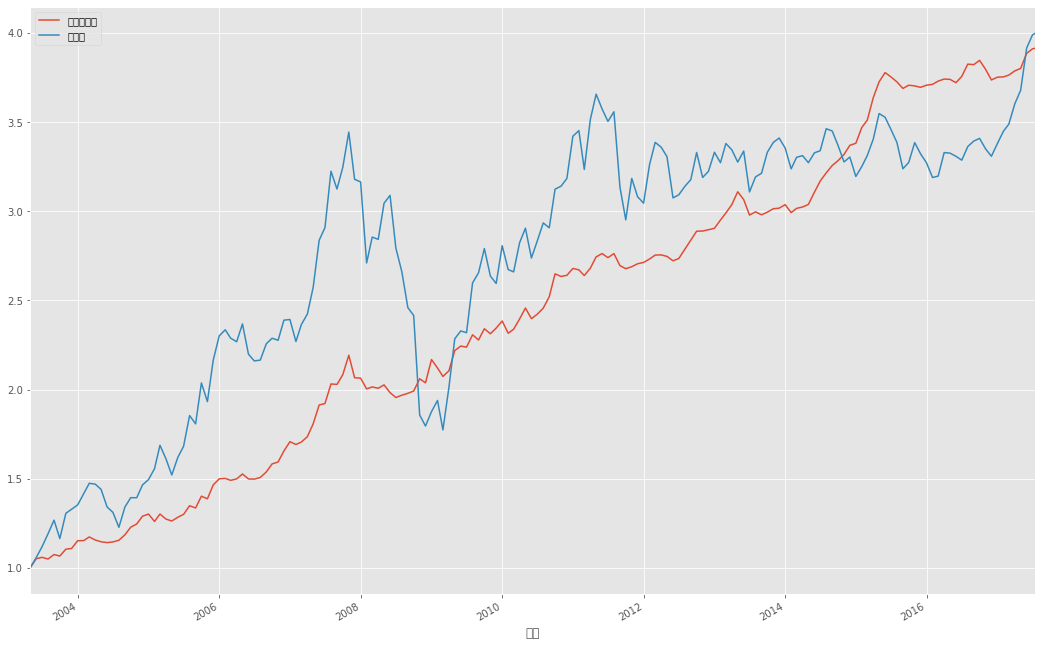

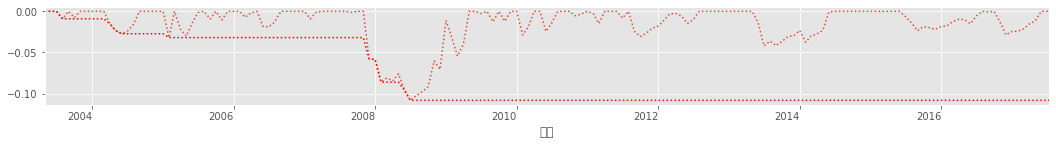

MDD : -10.8%
CAGR : 10.0%


In [5]:
# coding: utf-8
#1. 데이터 가져오기

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline


파일 = pd.ExcelFile('MPAA 데이터.xlsx')
자산군 = 파일.sheet_names
자산군


#2. 자산군별 데이터 프레임 설정

자료 = {}
for i in 자산군:
    자료[i] = 파일.parse(i)
    자료[i].index = 자료[i].날짜
    자료[i].drop('날짜', axis = 1, inplace=True)
    print(i+'개수',len(자료[i].columns))
    

#3. 함수 설정

def 월간수익률(데이터):
    return 데이터 / 데이터.shift(1)

#def 변동성대비모멘텀(데이터):
#    a = 데이터/데이터.shift(12)
#    b = 월간수익률(데이터).rolling(12).std()
#    return a/b

#def 연평균수익률(데이터):
#    return 데이터/데이터.shift(12)

def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

def 평균모멘텀스코어6(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 7):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/6
    return a

def 현금혼합모멘텀수익곡선(데이터, 현금비율=0.4):
    x = 월간수익률(자료['현금'])*현금비율
    a = pd.DataFrame((월간수익률(데이터).values*평균모멘텀스코어(데이터).shift(1).values+x.values)/(현금비율+평균모멘텀스코어(데이터).shift(1).values)).cumprod() 
    a.index = 데이터.index
    a.columns = 데이터.columns
    return a

def 자산군통합포트(데이터, 순위, 자산군비중):
    x = 월간수익률(현금혼합모멘텀수익곡선(데이터))
    y = np.where(모멘텀순위(데이터, 순위).shift(1)==0,np.nan,자산군비중/순위)
    z = ((x*y).sum(1)).dropna()
    z = z.replace(0, np.nan)
    return z

def 통합모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    a = 자산군통합포트(자료['국가'],4,국가비중)
    b = 자산군통합포트(자료['섹터'],8,섹터비중)
    c = 자산군통합포트(자료['팩터'],10,팩터비중)
    d = 자산군통합포트(자료['채권'],1,채권비중)
    e = (pd.concat([a, b, c, d], axis=1).sum(1)/(국가비중+섹터비중+팩터비중+채권비중))
    e = e.replace(0,np.nan).cumprod()
    e.columns = ['통합수익']
    return e

def 수익곡선모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    x = 월간수익률(자료['현금'])
    y = pd.DataFrame(통합모멘텀(국가비중,섹터비중,팩터비중,채권비중), index = x.index)    
    a = pd.DataFrame((월간수익률(y).values*평균모멘텀스코어6(y).shift(1).values+(1-평균모멘텀스코어6(y).shift(1).values)*x.values), index = x.index).cumprod().dropna()
    return a


# In[74]:

#4. 결과 plot
# 국가, 섹터, 팩터, 채권

a = 수익곡선모멘텀(2,1,1,2) ##여기 비중조절
b = 자료['국가'].KOSPI/자료['국가'].KOSPI.iloc[0]
c = pd.concat([a, b], axis=1).dropna()
c.columns = ['포트폴리오', '코스피']
c.divide(c.ix[0]).plot(figsize = (18,12))
plt.show()

#5. MDD
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

#6. MDD / CAGR
투자기간 = len(c.index)/12
print("MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("CAGR : "+str(c.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")


# # 


In [6]:
##최종 포트폴리오의 누적수익률
a

,0
날짜,
2003-04-30,1.009116
2003-05-31,1.060127
2003-06-30,1.068152
2003-07-31,1.058431
2003-08-31,1.083773
2003-09-30,1.075516
2003-10-31,1.114182
2003-11-30,1.118328
2003-12-31,1.162263


In [7]:
##수익률 데이터
x = 월간수익률(자료['현금'])
y = pd.DataFrame(통합모멘텀(2,1,1,2), index = x.index)    
a = pd.DataFrame((월간수익률(y).values*평균모멘텀스코어6(y).shift(1).values+(1-평균모멘텀스코어6(y).shift(1).values)*x.values), index = x.index)
a = a.dropna()
np.std(a[0].values) #포트폴리오의 변동성 2%

0.01911806681967116

# 코드 연습

In [1]:
x1=[1,2,3,4]
x2=[[1,2],[3,4]]
import numpy as np
#np.repeat(x1,2)
#np.repeat(x2,2,axis=1)
np.repeat(x2,[3,4],axis=1)

array([[1, 1, 1, 2, 2, 2, 2],
       [3, 3, 3, 4, 4, 4, 4]])

In [11]:
y

0      NaN
1      0.0
2      1.0
3      2.0
4      3.0
5      4.0
6      5.0
7      6.0
8      7.0
9      8.0
10     9.0
11    10.0
12    11.0
13    12.0
14    13.0
15    14.0
16    15.0
17    16.0
18    17.0
19    18.0
20    19.0
21    20.0
22    21.0
23    22.0
24    23.0
25    24.0
26    25.0
27    26.0
28    27.0
29    28.0
30    29.0
31    30.0
32    31.0
33    32.0
34    33.0
35    34.0
36    35.0
37    36.0
38    37.0
39    38.0
dtype: float64

In [15]:
x = pd.Series(np.arange(0,40))
y = x.shift(1)

pd.DataFrame({'전':x,'후':y})

,전,후
0,0,NaN
1,1,0.0
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [29]:
np.random.randint(0,1000,50)

array([213, 248,  97, 783, 511,   5, 117, 596, 552, 990, 971, 906, 486,
       701, 272, 601, 803, 476, 385, 227, 427,  53, 405, 857, 319, 695,
       725, 933,  63, 314, 608,   1, 228, 690, 765, 869, 179, 538, 239,
       961, 467,  43, 211, 506, 594, 567,  24, 808, 933,  14])

In [32]:
np.random.randn(100)

array([-1.66866175, -0.12554715,  3.1861904 ,  0.25240666, -1.49657323,
        0.61053044, -0.64122326,  1.26519699,  0.40657212, -1.55131119,
        0.2108198 , -1.30810976,  0.39114547, -0.90817349,  1.67122551,
       -0.80317691,  1.9306233 , -1.16488149,  1.34583082,  0.64165858])

In [38]:
index = pd.date_range(start='20130201',end='20150501',freq='M')
index

DatetimeIndex(['2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31',
               '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
               '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30'],
              dtype='datetime64[ns]', freq='M')

In [18]:
index = pd.date_range(start='20130201',end='20130801',freq='m')
val = np.random.randn(6,4)
columns = ['a','b','c','d']
pd.DataFrame(val, index=  index, columns = columns)

,a,b,c,d
2013-02-28,0.572998,-1.022662,1.149924,-1.546670
2013-03-31,-0.204075,-0.265095,-0.527083,-0.869655
2013-04-30,-0.613768,-0.620896,0.647571,1.342804
2013-05-31,-1.312310,-0.430415,0.425446,-0.326942
2013-06-30,0.959080,-0.590914,0.611396,-0.435190
2013-07-31,-0.922782,-0.162814,-0.580235,-1.524891


In [35]:
array1 = np.arange(20)
array2 = np.random.randint(0,1000,50)
array3 = np.random.randn(100)
import pandas as pd
series = pd.Series(array3)
#series.rolling(window=2).mean()
series.rolling(window=4).std()

0          NaN
1          NaN
2          NaN
3     1.289427
4     0.584213
        ...   
95    0.599109
96    0.809852
97    0.585143
98    0.685354
99    1.311538
Length: 100, dtype: float64

In [51]:
list('abcd')

['a', 'b', 'c', 'd']

In [52]:
[3]*4

[3, 3, 3, 3]

In [57]:
str_list = ['a','acd','dd','bda']
str_list.sort()
str_list

['a', 'acd', 'bda', 'dd']

In [60]:
str_list = ['a','acd','dd','bda']
sorted(str_list,key=lambda x: x*4)

['a', 'acd', 'bda', 'dd']

In [63]:
from sklearn.decomposition import PCA

In [65]:
pca_ex = pd.DataFrame(np.empty((60,5)))
pca = PCA(n_components=2)

In [70]:
pca.fit_transform(pca_ex) # return score vector 
pca.singular_values_ # return eigen value
pca.components_ # return weight vector

c:\users\owner\anaconda3\envs\dash_board\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


array([[-1.86986079e-04,  4.73635003e-05,  5.45782654e-05,
        -1.94696194e-04, -9.99999961e-01],
       [-1.62924372e-01,  6.72786320e-01, -7.20899123e-01,
        -3.34465438e-02,  2.94965969e-05]])

In [92]:
df = pd.DataFrame(np.empty((5,3)))
df[~df.isna()]=1

In [93]:
df

,0,1,2
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [106]:
response = pd.Categorical(values=['a','c','c','c','b','f'],ordered=True)
response

[a, c, c, c, b, f]
Categories (4, object): [a < b < c < f]

In [ ]:
diction = dict()
